# Sensor Fusion

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/Stheno.jl/blob/master/examples/sensor_fusion/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/sensor_fusion/).*

In [1]:
using AbstractGPs
using Plots
using Random
using Stheno

## Define and inspect our model

In [2]:
rng = MersenneTwister(123456);

In this example, `f` is an unknown real-valued function that we wish to infer. To achieve
this, we have access to two sensors. The first returns noisy estimates of `f`, where we have
been reliably informed by whoever designed the sensor that the mean of the noise is given by
`sin(x) - 5 + sqrt(abs(x))`, and that it's variance is low (1e-2). How the designer
estimated this function, and why a sensor might possibly have such a strange mean error, is
beyond the scope of this example. The second returns biased measurements of `f`, where the
bias is known to be 3.5. The model below specifies a model for this scenario.

In [3]:
model = @gppp let

    # Define a smooth latent process that we wish to infer.
    f = GP(SEKernel())

    # Define the two noise processes described.
    noise1 = sqrt(1e-2) * GP(WhiteKernel()) + (x->sin.(x) .- 5.0 .+ sqrt.(abs.(x)))
    noise2 = sqrt(1e-1) * GP(3.5, WhiteKernel())

    # Define the processes that we get to observe.
    y1 = f + noise1
    y2 = f + noise2
end;

Generate some toy observations of `y₁` and `y₂`.

In [4]:
x1 = GPPPInput(:y1, sort(rand(rng, 3) * 10));
x2 = GPPPInput(:y2, sort(rand(rng, 10) * 10));
x = BlockData(x1, x2);
ŷ = rand(rng, model(x));
ŷ1, ŷ2 = split(x, ŷ);

Compute the posterior processes.

In [5]:
model′ = posterior(model(x), ŷ);

Sample jointly from the posterior processes and compute posterior marginals.

In [6]:
xp_ = range(-2.5, stop=12.5, length=500);
xp_f = GPPPInput(:f, xp_);
xp_y1 = GPPPInput(:y1, xp_);
xp_y2 = GPPPInput(:y2, xp_);
xp = BlockData(xp_f, xp_y1, xp_y2);
model′_xp = rand(rng, model′(xp, 1e-9));
f′xp, y1′xp, y2′xp = split(xp, model′_xp);

## Plot results

In [7]:
gr();

posterior_plot = plot();

Plot posterior over y1.

In [8]:
plot!(posterior_plot, xp_, model′(xp_y1); color=:red, label="y1");
plot!(posterior_plot, xp_, y1′xp; color=:red, label="", linewidth=1, linealpha=0.2);

Plot posterior over y2.

In [9]:
plot!(posterior_plot, xp_, model′(xp_y2); color=:green, label="y2");
plot!(posterior_plot, xp_, y2′xp; color=:green, label="", linewidth=1, linealpha=0.2);

Plot posterior over f.

In [10]:
plot!(posterior_plot, xp_, model′(xp_f); color=:blue, label="Latent Function");
plot!(posterior_plot, xp_, f′xp; color=:blue, label="", linewidth=1, linealpha=0.2);

Plot samples on which we conditioned.

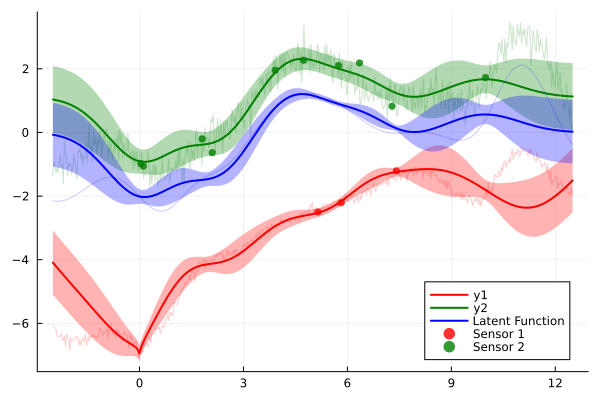

In [11]:
scatter!(posterior_plot, x1.x, ŷ1;
    markercolor=:red,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=4,
    markeralpha=0.8,
    label="Sensor 1",
);
scatter!(posterior_plot, x2.x, ŷ2;
    markercolor=:green,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=4,
    markeralpha=0.8,
    label="Sensor 2",
);

posterior_plot

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*